In [1]:
import torch 
import math
import numpy as np
import ot 
import plotly.express as px
import scipy
from matplotlib import pyplot as plt
from matplotlib import cm
from tqdm import tqdm
from abc import ABC, abstractmethod
from matplotlib.colors import Normalize
from matplotlib.collections import LineCollection
from geomloss import SamplesLoss


torch.set_default_dtype(torch.float64)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_device(device)

## Utils

In [2]:
def torch_divmod(n: torch.Tensor, d: int) -> tuple[torch.Tensor, torch.Tensor]:
    """
    Equivalent to divmod for tensors. TODO If implemented nicely in pytorch, could submit a PR. 

    parameters:
        n: torch.Tensor, shape [...]
        d: int

    returns:
        tuple of tensors, shape [...]
    """
    return n // d, n % d


def joint_multinomial(distribution: torch.Tensor, num_samples: int, replacement: bool = True) -> torch.Tensor:
    """
    Sample from a joint categorical distribution.

    parameters:
        distribution: torch.Tensor, shape (N, M)
        num_samples: int, number of samples to draw
        replacement: bool, whether to sample with replacement

    returns:
        torch.Tensor, shape (num_samples, 2)
    """
    n, _ = distribution.shape
    res = torch.multinomial(distribution.flatten(), num_samples, replacement=replacement)
    res_i, res_j = torch_divmod(res, n)
    return torch.column_stack([res_i, res_j])


def as_tensors(*args, dtype: torch.dtype | None = None, device: torch.device | None = None) -> tuple[torch.Tensor, ...]:
    """
    Convert all arguments to tensors.
    """
    return tuple(torch.as_tensor(arg, dtype=dtype, device=device) for arg in args)

## SDEs and SDE solvers

In [45]:
class SDE(ABC):
    """
    Base class for Diagonalizable SDEs. 
    """
    def __init__(self, dim: int, *, device: torch.device | None = None):
        self._dim = dim 
        self.device = device 

    def to(self, device: torch.device | None = None) -> "SDE":
        if device is not None:
            self.device = device 
        return self 

    @property
    def dim(self) -> int:
        return self._dim 
    
    @abstractmethod
    def drift(
        self, 
        t: torch.Tensor,
        x: torch.Tensor,
    ) -> torch.Tensor:
        pass 

    @abstractmethod
    def diffusion(
        self, 
        t: torch.Tensor,
        x: torch.Tensor,
    ) -> torch.Tensor:
        pass 

    @abstractmethod
    def transition(
        self, 
        t0: torch.Tensor, 
        t1: torch.Tensor,
    ) -> torch.Tensor:
        pass

    def _mean(self, t: torch.Tensor) -> torch.Tensor:
        raise NotImplementedError("Unconditional mean not implemented for this SDE.") 

    @abstractmethod
    def _mean_with_initial_condition(
        self, 
        t: torch.Tensor, 
        *, 
        t0: torch.Tensor | None = None,
        x0: torch.Tensor | None = None,
    ) -> torch.Tensor:
        pass 

    @abstractmethod
    def _mean_with_initial_and_final_condition(
        self, 
        t: torch.Tensor, 
        *, 
        t0: torch.Tensor | None = None,
        x0: torch.Tensor | None = None,
        t1: torch.Tensor | None = None,
        x1: torch.Tensor | None = None,
    ) -> torch.Tensor:
        pass 

    def mean(
        self, 
        t: torch.Tensor, 
        *,
        t0: torch.Tensor | None = None, 
        x0: torch.Tensor | None = None,
        t1: torch.Tensor | None = None,
        x1: torch.Tensor | None = None,
    ) -> torch.Tensor:
        """
        Returns the mean of the SDE at time t. May be conditioned on initial and/or final conditions. 
        If t0 and t1 are True, then t0 = 0 and t1 = 1. 

        parameters: 
            t (torch.Tensor): [...] Times.
            t0 (torch.Tensor): [...] Start times.
            x0 (torch.Tensor): [..., D] Initial value.
            t1 (torch.Tensor): [...] End times.

        returns: 
            torch.Tensor: [..., D] Mean.
        """
        if x0 is not None and x1 is not None:
            if t0 is None:
                t0 = t.new_zeros(t.shape) # [...]
            if t1 is None:
                t1 = t.new_ones(t.shape) # [...]
            return self._mean_with_initial_and_final_condition(t=t, t0=t0, x0=x0, t1=t1, x1=x1)
        elif x0 is not None:
            if t0 is None:
                t0 = t.new_zeros(t.shape) # [...]
            return self._mean_with_initial_condition(t=t, t0=t0, x0=x0)
        else:
            return self._mean(t)

    def _variance(
        self, 
        t: torch.Tensor, 
    ) -> torch.Tensor:
        raise NotImplementedError("Unconditional variance not implemented for this SDE.") 

    @abstractmethod
    def _variance_with_initial_condition(
        self, 
        t: torch.Tensor, 
        *, 
        t0: torch.Tensor | None = None,
    ) -> torch.Tensor:
        pass 

    def _variance_with_initial_and_final_condition(
        self, 
        t: torch.Tensor, 
        *, 
        t0: torch.Tensor | None = None, 
        t1: torch.Tensor | None = None,
    ) -> torch.Tensor:
        """
        Returns the variance of the SDE at time t, conditioned on being zero variance at time t0 and t1.

        parameters: 
            t (torch.Tensor): [...] Times.
            t0 (torch.Tensor): [...] Conditioning times.
            t1 (torch.Tensor): [...] Conditioning times.

        returns: 
            torch.Tensor: [..., D] Diagonal of the conditional variance of the SDE.
        """
        sigmatt = self.variance(t=t, t0=t0)
        sigmat1t = self.covariance(s=t, t=t1, t0=t0)
        sigmat1t1 = self.variance(t=t1, t0=t0)

        return sigmatt - sigmat1t.square() / sigmat1t1

    def variance(
        self, 
        t: torch.Tensor, 
        *, 
        t0: torch.Tensor | bool | None = None, 
        t1: torch.Tensor | bool | None = None,
    ) -> torch.Tensor:
        """
        Returns the variance of the SDE at time t. May be conditioned on initial and/or final conditions. 
        If t0 and t1 are True, then t0 = 0 and t1 = 1. 

        parameters: 
            t (torch.Tensor): [...] Times.
            t0 (torch.Tensor): [...] Start times.
            t1 (torch.Tensor): [...] End times.
        
        returns: 
            torch.Tensor: [..., D] Variance.
        """
        if t0 is True:
            t0 = t.new_zeros(t.shape) # [...]
        if t1 is True:
            t1 = t.new_ones(t.shape) # [...]
        if t0 is not None and t1 is not None:
            return self._variance_with_initial_and_final_condition(t=t, t0=t0, t1=t1)
        elif t0 is not None:
            return self._variance_with_initial_condition(t=t, t0=t0)
        else:
            return self._variance(t)

    def _covariance(
        self, 
        s: torch.Tensor,
        t: torch.Tensor,
    ) -> torch.Tensor:
        raise NotImplementedError("Unconditional covariance not implemented for this SDE.") 

    def _covariance_with_initial_condition(
        self, 
        s: torch.Tensor, 
        t: torch.Tensor, 
        *, 
        t0: torch.Tensor | None = None,
    ) -> torch.Tensor:
        """
        Returns the covariance of the SDE between times s and t conditioned on being at x0 at time t0. 

        parameters: 
            s (torch.Tensor): [...] Start times.
            t (torch.Tensor): [...] End times.
            t0 (torch.Tensor): [...] Conditioning times.
        returns: 
            torch.Tensor: [..., D] Diagonal of the (diagonal) covariance matrix.
        """
        r = torch.minimum(s, t)
        return self.transition(t0=r, t1=t) * self.variance(t=r, t0=t0) * self.transition(t0=r, t1=s)

    def _covariance_with_initial_and_final_condition(
        self, 
        s: torch.Tensor,
        t: torch.Tensor,
        *, 
        t0: torch.Tensor | None = None,
        t1: torch.Tensor | None = None,
    ) -> torch.Tensor:
        # This could be implemented already here by conditioning of Gaussian processes, but is not needed for now. 
        raise NotImplementedError("Unconditional covariance not implemented yet. Can be implemented by the Gaussian process conditioning rule.") 

    def covariance(
        self, 
        s: torch.Tensor, 
        t: torch.Tensor, 
        *, 
        t0: torch.Tensor | bool | None = None, 
        t1: torch.Tensor | bool | None = None,
    ) -> torch.Tensor:
        if (t0 is True or t0 is not None) and (t1 is True or t1 is not None):
            return self._covariance_with_initial_and_final_condition(s=s, t=t, t0=t0, t1=t1)
        elif (t0 is True or t0 is not None):
            return self._covariance_with_initial_condition(s=s, t=t, t0=t0)
        else: 
            return self._covariance(s=s, t=t)

    @abstractmethod
    def marginal_distribution(
        self, 
        t: torch.Tensor,
        t0: torch.Tensor | None = None, 
        x0: torch.Tensor | None = None,
        t1: torch.Tensor | None = None,
        x1: torch.Tensor | None = None,
    ) -> torch.Tensor:
        """
        Returns the marginal distribution of the SDE at time t. May be conditioned on initial and/or final conditions. 
        If t0 and t1 are True, then t0 = 0 and t1 = 1. 

        parameters: 
            t (torch.Tensor): [...] Times.
            t0 (torch.Tensor): [...] Start times.
            x0 (torch.Tensor): [..., D] Initial value.
            t1 (torch.Tensor): [...] End times.
            x1 (torch.Tensor): [..., D] Target value.

        returns: 
            torch.Tensor: [..., D] Marginal distribution at time t. 
        """


class DiagonalizableSDE(SDE):
    @abstractmethod
    def inverse_transform(self, x: torch.Tensor) -> torch.Tensor:
        """
        Transforms the points from eigencoordinates to the original coordinates. 

        parameters: 
            x (torch.Tensor): [..., D] Points in eigencoordinates.

        returns: 
            torch.Tensor: [..., D] Points in original coordinates.
        """
        pass

    def marginal_distribution(
        self, 
        t: torch.Tensor,
        t0: torch.Tensor | None = None, 
        x0: torch.Tensor | None = None,
        t1: torch.Tensor | None = None,
        x1: torch.Tensor | None = None,
    ) -> torch.Tensor:
        """
        Returns the marginal distribution of the SDE at time t. May be conditioned on initial and/or final conditions. 
        If t0 and t1 are True, then t0 = 0 and t1 = 1. 

        parameters: 
            t (torch.Tensor): [...] Times.
            t0 (torch.Tensor): [...] Start times.
            x0 (torch.Tensor): [..., D] Initial value.
            t1 (torch.Tensor): [...] End times.
            x1 (torch.Tensor): [..., D] Target value.

        returns: 
            torch.Tensor: [..., D] Marginal distribution at time t. 
        """
        if x0 is not None and t0 is None:
            t0 = t.new_zeros(t.shape) # [...]
        if x1 is not None and t1 is None:
            t1 = t.new_ones(t.shape) # [...]

        mean = self.mean(t=t, t0=t0, x0=x0, t1=t1, x1=x1)
        # FIXME variance returns negative values
        variance = self.variance(t=t, t0=t0, t1=t1)
        normal = torch.distributions.Normal(loc=mean, scale=variance.sqrt())
        return torch.distributions.Independent(normal, reinterpreted_batch_ndims=1)


class OUDiagonalizableSDE(DiagonalizableSDE):
    def __init__(self, alpha_diagonal: torch.Tensor, gamma_diagonal: torch.Tensor, device: torch.device | None = None):
        """
        Creates the diagonal OU SDE.

        ..math:: 
            dX_t = \alpha X_t dt + \gamma dW_t

        parameters: 
            alpha_diagonal (torch.Tensor): [D] Vector representing the diagonal of the (diagonal)drift matrix alpha.
            gamma_diagonal (torch.Tensor): [D] Vector representing the diagonal of the (diagonal) diffusion matrix gamma.
        """
        dim = alpha_diagonal.shape[0]
        super().__init__(dim=dim, device=device)
        self.alpha_diagonal = alpha_diagonal.to(device)
        self.gamma_diagonal = gamma_diagonal.to(device)

    def to(self, device: torch.device) -> "OUDiagonalizableSDE":
        super().to(device)
        self.alpha_diagonal = self.alpha_diagonal.to(device)
        self.gamma_diagonal = self.gamma_diagonal.to(device)
        return self 

    def drift(self, t: torch.Tensor | None = None, x: torch.Tensor | None = None) -> torch.Tensor:
        """
        Returns the drift of the SDE. 

        parameters: 
            t (torch.Tensor): [...] Times.
            x (torch.Tensor): [..., D] Initial value.

        returns: 
            torch.Tensor: [..., D] Drift of the SDE.
        """
        return self.alpha_diagonal * x

    def diffusion(self, t: torch.Tensor | None = None, x: torch.Tensor | None = None) -> torch.Tensor:
        """
        Returns the diffusion of the SDE. 

        parameters: 
            t (torch.Tensor): [...] Times.

        returns: 
            torch.Tensor: [D] Diffusion of the SDE.
        """
        return self.gamma_diagonal

    def transition(self, t0: torch.Tensor, t1: torch.Tensor) -> torch.Tensor:
        """
        Returns a vector representing the transition matrix, which is itself a diagonal matrix. 

        parameters: 
            t0 (torch.Tensor): [...] Start times.
            t1 (torch.Tensor): [...] End times.

        returns: 
            torch.Tensor: [..., D] Diagonal of the transition matrix.
        """
        delta = t1 - t0 # [...]
        return torch.exp(torch.einsum("d, ... -> ...d", self.alpha_diagonal, delta))

    def _variance_with_initial_condition(
        self, 
        t: torch.Tensor, 
        *, 
        t0: torch.Tensor | None = None,
        min_alpha_nonzero: float = 1e-8
    ) -> torch.Tensor:
        """
        Returns the variance of the SDE at time t, conditioned on being zero-variance at time t0.

        parameters: 
            t (torch.Tensor): [...] Times.
            t0 (torch.Tensor): [...] Conditioning times.

        returns: 
            torch.Tensor: [..., D] Diagonal of the variance of the SDE.
        """
        variance_if_alpha_zero = torch.einsum('d, ... -> ...d', self.gamma_diagonal.square(), (t - t0)) # [..., D]        
        variance_if_alpha_nonzero = (
            self.gamma_diagonal.square() * (self.transition(t0=t0, t1=t).square() - 1) / (2 * self.alpha_diagonal)
        ) # [..., D]
        return torch.where(self.alpha_diagonal.abs() < min_alpha_nonzero, variance_if_alpha_zero, variance_if_alpha_nonzero) # [..., D]

    def _mean_with_initial_condition(self, t: torch.Tensor, t0: torch.Tensor | None = None, x0: torch.Tensor | None = None) -> torch.Tensor:
        """
        Returns the mean of the SDE conditioned on being at x0 at time t0.
        
        parameters: 
            t (torch.Tensor): [...] Times.
            t0 (torch.Tensor): [...] Start times.
            x0 (torch.Tensor): [..., D] Initial value.

        returns: 
            torch.Tensor: [..., D] Mean of the SDE.
        """
        return self.transition(t0=t0, t1=t) * x0 # [..., D] * [..., D] -> [..., D]

    def _mean_with_initial_and_final_condition(self, t: torch.Tensor, t0: torch.Tensor | None = None, x0: torch.Tensor | None = None, t1: torch.Tensor | None = None, x1: torch.Tensor | None = None) -> torch.Tensor:
        """
        Returns the mean of the SDE conditioned on being at x0 at time t0 and x1 at time t1. 

        parameters: 
            t (torch.Tensor): [...] End times.
            t0 (torch.Tensor): [...] Start times.
            x0 (torch.Tensor): [..., D] Initial value.
            t1 (torch.Tensor): [...] End times.
            x1 (torch.Tensor): [..., D] Target value.

        returns: 
            torch.Tensor: [..., D] Conditional mean of the SDE.
        """
        m_t = self._mean_with_initial_condition(t=t, t0=t0, x0=x0)
        m_t1 = self._mean_with_initial_condition(t=t1, t0=t0, x0=x0)
        sigma_t1t = self.covariance(s=t, t=t1, t0=t0) # FIXME This should be symmetric but is antisymmetric
        sigma_t1t1 = self.variance(t=t1, t0=t0)
        return m_t + sigma_t1t / sigma_t1t1 * (x1 - m_t1)
     

class HeatBMTSDE(OUDiagonalizableSDE):
    def __init__(self, L: torch.Tensor, c: torch.Tensor, sigma: torch.Tensor, device: torch.device | None = None, q_brownian_motion: bool = False, alpha: float | None = None):
        """
        Creates the heat BM SDE:

        ..math:: 
            dX_t = -cLX_t dt + \sigma dW_t

        parameters: 
            L (torch.Tensor): [D, D] Matrix representing the Laplacian.
            c (torch.Tensor): [] Scalar greater than or equal to 0.
            sigma (torch.Tensor): [] Scalar diffusion coefficient.
        """
        L = torch.as_tensor(L, device=device)
        c = torch.as_tensor(c, device=device)
        sigma = torch.as_tensor(sigma, device=device)
        
        eigenvalues, eigenvectors = torch.linalg.eigh(L)
        alpha_diagonal = -c * eigenvalues
        if q_brownian_motion:
            alpha = alpha or (L.shape[0] / 2.0 + 1.0) # TODO Add a better default. Alpha must be greater that dim / 2 though
            Q_diagonal = (torch.ones_like(eigenvalues) - eigenvalues).pow(-alpha)
            gamma_diagonal = sigma * Q_diagonal.sqrt()
        else:
            gamma_diagonal = sigma * torch.ones_like(eigenvalues) # TODO Add a Q-Brownian motion option. If true, multiply by sqrt(eigenvalues)
        
        super().__init__(alpha_diagonal=alpha_diagonal, gamma_diagonal=gamma_diagonal, device=device)
        self.eigenvalues = eigenvalues.to(device)
        self.eigenvectors = eigenvectors.to(device)

    def to(self, device: torch.device) -> "HeatBMTSDE":
        super().to(device)
        self.eigenvalues = self.eigenvalues.to(device)
        self.eigenvectors = self.eigenvectors.to(device)
        return self 

    def inverse_transform(self, x: torch.Tensor) -> torch.Tensor:
        """
        Returns the inverse transform of the SDE. 

        parameters: 
            x (torch.Tensor): [..., D] Initial value.

        returns: 
            torch.Tensor: [..., D] Inverse transform of the SDE.
        """
        return torch.einsum("ij, ...j -> ...i", self.eigenvectors, x) # [D, D] * [..., D] -> [..., D]


class UniformTimesteps:
    def __init__(self, n: int, device: torch.device | None = None, dtype: torch.dtype | None = None, t0: float | None = 1e-4):
        assert n > 1, "Number of timesteps must be greater than 1"
        self.n = n
        self.t = torch.linspace(0, 1, n + 1, dtype=dtype, device=device)
        if t0 is not None:
            self.t[0] = t0
        
        self.dt = torch.full((n, ), 1.0 / n, dtype=dtype, device=device)
        self.device = device 
    
    def to(self, device: torch.device | None = None) -> "UniformTimesteps":
        if device is not None:
            self.t = self.t.to(device)
            self.dt = self.dt.to(device)
            self.device = device
        return self 

## Controls

In [46]:
def bridge_control(
    sde: SDE, 
    t: torch.Tensor, 
    x: torch.Tensor, 
    *, 
    t1: torch.Tensor | None = None, 
    x1: torch.Tensor,
) -> torch.Tensor:
    """
    Returns the control for the bridge of the SDE at time t and position x needed to reach x1 at time t1. 

    parameters: 
        sde (SDE): The SDE to create the bridge control for.
        t (torch.Tensor): [...] Current times.
        x (torch.Tensor): [..., D] Current values.
        t1 (torch.Tensor): [...] Target times.
        x1 (torch.Tensor): [..., D] Target values.

    returns: 
        torch.Tensor: [..., D] Control.
    """
    if t1 is None:
        t1 = x1.new_ones(x1.shape[:-1]) # [...]
    score = sde.transition(t0=t, t1=t1) * (x1 - sde.mean(t0=t, x0=x, t=t1)) / sde.variance(t0=t, t=t1)
    return sde.diffusion(t=t).square() * score


class Control:
    def __init__(self, device: torch.device | None = None):
        self.device = None

    def to(self, device: torch.device) -> "Control":
        self.device = device 
        return self 

    @abstractmethod
    def control(self, t: torch.Tensor, x: torch.Tensor, **kwargs) -> torch.Tensor:
        pass 

    def __call__(self, t: torch.Tensor, x: torch.Tensor, **kwargs) -> torch.Tensor:
        """
        Returns the control at time t and position x. 

        parameters: 
            t (torch.Tensor): [...] times.
            x (torch.Tensor): [..., D] values.

        returns: 
            torch.Tensor: [..., D] Control.
        """
        return self.control(t=t, x=x, **kwargs)


class ZeroControl(Control):
    def control(self, t: torch.Tensor, x: torch.Tensor) -> torch.Tensor:
        return x.new_zeros(x.shape) # [..., D]


class BridgeControl(Control):
    def __init__(self, sde: SDE, x1: torch.Tensor, t1: torch.Tensor | None = None, device: torch.device | None = None): 
        """
        Creates the bridge control for the SDE conditioned on being at x1 at time t1. 

        parameters: 
            sde (SDE): The SDE to create the bridge control for.
            x1 (torch.Tensor): [..., D] Target value.
            t1 (torch.Tensor): [...] End times.
        """
        super().__init__(device=device)
        self.sde = sde.to(device)
        x1 = x1.to(device)
        self._x1 = None
        self._t1 = None
        self.condition(x1=x1, t1=t1)

    def to(self, device: torch.device) -> "BridgeControl":
        super().to(device)
        self.sde = self.sde.to(device)
        self._x1 = self._x1.to(device)
        self._t1 = self._t1.to(device)
        return self 

    def condition(self, x1: torch.Tensor, t1: torch.Tensor | None = None) -> "BridgeControl":
        """
        Conditions the bridge on being at x1 at time t1. 

        parameters: 
            x1 (torch.Tensor): [..., D] Target value.
            t1 (torch.Tensor): [...] End times.

        returns: 
            BridgeControl: The bridge control.
        """
        if t1 is None:
            t1 = x1.new_ones(x1.shape[:-1]) # [...]
        self._x1 = x1
        self._t1 = t1
        return self

    def control(self, t: torch.Tensor, x: torch.Tensor) -> torch.Tensor:
        """
        Returns the control for the bridge at time t and position x. 

        parameters: 
            t (torch.Tensor): [...] times.
            x (torch.Tensor): [..., D] values.

        returns: 
            torch.Tensor: [..., D] Control.
        """
        return bridge_control(sde=self.sde, t=t, x=x, t1=self._t1, x1=self._x1)


class ModelControl(Control):
    def __init__(self, model: torch.nn.Module, device: torch.device | None = None):
        super().__init__(device=device)
        self.model = model.to(device)

    def to(self, device: torch.device | None = None) -> "ModelControl":
        super().to(device)
        self.model = self.model.to(device)
        return self 

    def __call__(self, t: torch.Tensor, x: torch.Tensor) -> torch.Tensor:
        return self.model(t, x)


## SDE solvers

In [47]:
class EulerMaruyamaSolver(torch.nn.Module):
    def __init__(self, sde: SDE, n: int, timesteps: str = "uniform"):
        # TODO Consider whether to move the SDE into sample_path.
        super().__init__()
        self.sde = sde

        if timesteps == "uniform":
            self.timesteps = UniformTimesteps(n)
        else:
            raise ValueError(f"Invalid timesteps: {timesteps}")

    def dx(self, dt: torch.Tensor, t: torch.Tensor, x: torch.Tensor, *, control: Control) -> torch.Tensor:
        """
        Returns the change in the SDE. 

        parameters: 
            dt (torch.Tensor): [] Duration of the timestep.
            t (torch.Tensor): [] Time.
            x (torch.Tensor): [..., D] Initial value.
            control (Control): Control object.

        returns: 
            torch.Tensor: [..., D] Change in the SDE.
        """
        t = t.expand(x.shape[:-1])
        drift = self.sde.drift(t=t, x=x) + control(t=t, x=x)
        diffusion = self.sde.diffusion(t=t, x=x)
        return drift * dt + diffusion * torch.sqrt(dt) * torch.randn_like(x)

    def sample_from_terminal(self, x0: torch.Tensor, *, control: Control | None = None) -> torch.Tensor:
        """
        Samples from terminal distribution by running the SDE forward from time 0 to 1.

        parameters: 
            x0 (torch.Tensor): [..., D] Initial value.
            control (Control): Control object.

        returns: 
            torch.Tensor: [..., D] Terminal value.
        """
        if control is None:
            control = ZeroControl()

        ts = self.timesteps.t
        dts = self.timesteps.dt

        x = x0
        for t, dt in zip(ts[:-1], dts):
            x = x + self.dx(dt=dt, t=t, x=x, control=control)
        return x 

    def sample_path(self, x0: torch.Tensor, *, control: Control | None = None) -> tuple[torch.Tensor, torch.Tensor]:
        """
        Samples a path from the SDE.

        parameters: 
            x0 (torch.Tensor): [..., D] Initial value.
            control (Control): Control object.

        returns: 
            tuple[torch.Tensor, torch.Tensor]: [..., T, D] Path and [T] Time.
        """

        if control is None:
            control = ZeroControl()

        ts = self.timesteps.t
        dts = self.timesteps.dt

        x = x0
        xs = [x]
        for t, dt in zip(ts[:-1], dts):
            x = x + self.dx(dt=dt, t=t, x=x, control=control)
            xs.append(x)
        return torch.stack(xs, dim=-2), ts

## Optimal Transport

In [48]:
class EntropicOTSolver:
    def __init__(self, sde: SDE, normalize_variance: bool = True):
        self.sde = sde 
        # TODO might need to put the variance on the right device, so maybe SDE should have a device attribute?
        variance = self.sde.variance(t0=torch.tensor(0.0), t=torch.tensor(1.0))

        if normalize_variance:
            self._epsilon = torch.prod(variance).pow(1.0 / self.sde.dim)
            self.normed_stddev = torch.sqrt(variance / self.epsilon) # [..., D]
        else:
            self._epsilon = torch.tensor(1.0)
            self.normed_stddev = torch.sqrt(variance) # [..., D]

    @property
    def epsilon(self) -> torch.Tensor:
        """
        Returns the epsilon parameter for the entropic OT.

        .. math::
           \min_{\pi \in \Pi(\mu, \nu)} \mathbb{E}_{(x, y) \sim \pi}[c(x, y)] + \epsilon H(\pi)

        returns: 
            torch.Tensor: [..., D] Epsilon parameter. 
        """
        return self._epsilon

    def cost(self, x0: torch.Tensor, x1: torch.Tensor) -> torch.Tensor:
        """
        Returns the cost between x0 and x1.

        parameters:
            x0 (torch.Tensor): [..., D] Initial value.
            x1 (torch.Tensor): [..., D] Target value.

        returns: 
            torch.Tensor: [...] Optimal transport cost.
        """

        t0 = x0.new_zeros(x0.shape[:-1])
        t1 = x1.new_ones(x1.shape[:-1])
        z = (x1 - self.sde.mean(t0=t0, x0=x0, t=t1)) / self.normed_stddev # ([..., D] - [..., D]) / [D] -> [..., D]
        return torch.linalg.vector_norm(z, ord=2, dim=-1) # [..., D] -> [...]

    def cost_matrix(self, x0: torch.Tensor, x1: torch.Tensor) -> torch.Tensor:
        """
        Returns the cost matrix between x0 and x1.

        parameters: 
            x0 (torch.Tensor): [..., N, D] Initial value.
            x1 (torch.Tensor): [..., M, D] Target value.

        returns: 
            torch.Tensor: [..., N, M] Cost matrix.
        """
        assert x0.ndim >= 2, "x0 must have at least 2 dimensions"
        assert x1.ndim >= 2, "x1 must have at least 2 dimensions"

        # Expand x0 and x1 for broadcasting
        # x0_expanded: [..., N, 1, D]
        # x1_expanded: [..., 1, M, D]
        x0_expanded = x0.unsqueeze(-2)  # [..., N, 1, D]
        x1_expanded = x1.unsqueeze(-3)  # [..., 1, M, D]

        # Compute cost for each pair (n, m)
        # Use the same cost as in self.cost, but vectorized
        t0 = x0.new_zeros(x0.shape[:-2] + (x0.shape[-2], 1))  # [..., N, 1]
        t1 = x1.new_ones(x0.shape[:-2] + (1, x1.shape[-2]))   # [..., 1, M]
        # mean: [..., N, 1, D]
        mean = self.sde.mean(t0=t0, x0=x0_expanded, t=t1)
        # normed_variance: [D]
        z = (x1_expanded - mean) / self.normed_stddev  # ([..., 1, M, D] - [..., N, 1, D]) / [D] -> [..., N, M, D]
        cost = torch.linalg.vector_norm(z, ord=2, dim=-1)  # [..., N, M]
        return cost
        
    def solve(
        self, 
        x0: torch.Tensor, 
        x1: torch.Tensor, 
        method: str = "sinkhorn",
        num_iter_max: int = 1000,
        stop_threshold: float = 1e-9,
        verbose: bool = False,
        log: bool = False,
        warn: bool = True,
    ) -> torch.Tensor:
        """
        Returns the optimal transport plan between x0 and x1.

        parameters: 
            x0 (torch.Tensor): [N, D] Initial value.
            x1 (torch.Tensor): [M, D] Target value.

        returns: 
            torch.Tensor: [N, M] Optimal transport plan.
        """
        assert x0.ndim == 2, "x0 must have 2 dimensions"
        assert x1.ndim == 2, "x1 must have 2 dimensions"

        cost_matrix = self.cost_matrix(x0, x1)
        px0 = x0.new_ones(x0.shape[0]) / x0.shape[0]
        px1 = x1.new_ones(x1.shape[0]) / x1.shape[0]

        # convert to numpy
        cost_matrix = cost_matrix.detach().cpu().numpy()
        px0 = px0.detach().cpu().numpy()
        px1 = px1.detach().cpu().numpy()
        epsilon = self.epsilon.detach().cpu().numpy()

        optimal_plan = ot.sinkhorn(
            a=px0, 
            b=px1, 
            M=cost_matrix, 
            reg=epsilon, 
            method=method,
            num_iter_max=num_iter_max, 
            stop_threshold=stop_threshold, 
            verbose=verbose, 
            log=log, 
            warn=warn
        )

        return torch.as_tensor(optimal_plan, device=x0.device, dtype=x0.dtype)

## Data

In [39]:
class TimeSampler(ABC):
    """
    Abstract class for time samplers.
    """

    def __init__(self, device: torch.device | None = None, dtype: torch.dtype | None = None):
        self.device = device
        self.dtype = dtype

    def to(self, device: torch.device) -> "TimeSampler":
        self.device = device
        return self

    @abstractmethod
    def sample(self, shape: torch.Size) -> torch.Tensor:
        pass


class UniformTimeSampler(TimeSampler):

    def sample(self, shape: torch.Size) -> torch.Tensor:
        return torch.rand(shape, device=self.device, dtype=self.dtype)


class DiscreteTimeSampler(TimeSampler):
    def __init__(self, timesteps: UniformTimesteps, device: torch.device | None = None, dtype: torch.dtype | None = None):
        super().__init__(device, dtype)
        self.timesteps = timesteps

    def sample(self, shape: torch.Size) -> torch.Tensor:
        indices = torch.randint(0, self.timesteps.n - 1, shape, device=self.device, dtype=self.dtype)
        return self.timesteps.t[indices]


class MatchingDataset(torch.utils.data.Dataset):
    def __init__(self, x0: torch.Tensor, x1: torch.Tensor, time_sampler: UniformTimeSampler | None = None):
        super().__init__()
        self.x0 = x0
        self.x1 = x1
        self.time_sampler = time_sampler or UniformTimeSampler(device=x0.device, dtype=x0.dtype)
    
    def __getitem__(self, idx: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        """
        returns:
            t: torch.Tensor, shape [...]
            x0: torch.Tensor, shape [..., D]
            x1: torch.Tensor, shape [..., D]
        """
        x0_idx, x1_idx = torch.unbind(idx, dim=-1)
        t = self.time_sampler.sample(x0_idx.shape)
        return t, self.x0[x0_idx], self.x1[x1_idx]
    
    def __len__(self) -> int:
        raise NotImplementedError("Length of MatchingDataset is not defined.")
        

class OTBatchSampler(torch.utils.data.Sampler):
    def __init__(self, dataset: MatchingDataset, ot_solver: EntropicOTSolver, batch_size: int, num_samples: int):
        super().__init__()
        self.dataset = dataset
        self.joint_distribution = ot_solver.solve(dataset.x0, dataset.x1)
        self.batch_size = batch_size
        self.num_samples = num_samples

    def __iter__(self):
        for _ in range(len(self)):
            yield joint_multinomial(self.joint_distribution, self.batch_size)

    def __len__(self) -> int:
        return self.num_samples // self.batch_size


class MatchingDataLoader:
    def __init__(self, dataset: MatchingDataset, batch_sampler: OTBatchSampler):
        self.dataset = dataset
        self.batch_sampler = batch_sampler

    def __iter__(self):
        for batch in self.batch_sampler:
            yield self.dataset[batch]

    def __len__(self) -> int:
        return len(self.batch_sampler)

# 2d Linear Gaussian bridge example

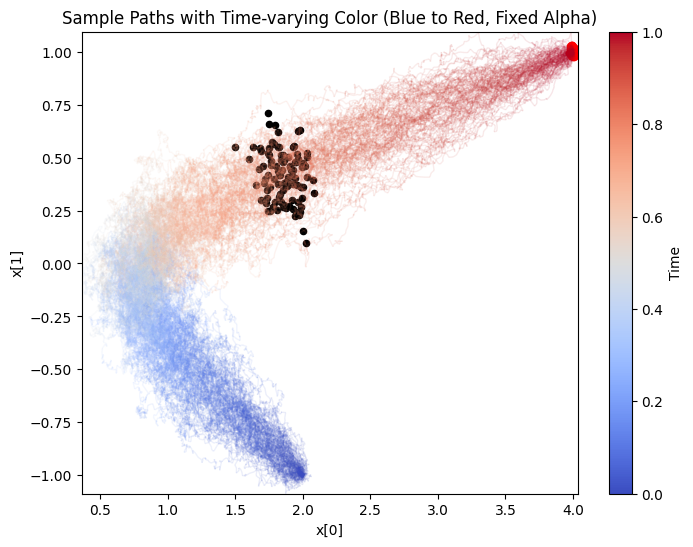

In [40]:
dim = 2
L = torch.eye(dim)
c = 4.0
sigma = 0.4
n = 1000

sde = HeatBMTSDE(L=L, c=c, sigma=sigma)
sde_solver = EulerMaruyamaSolver(sde=sde, n=n)

delta_x = torch.tensor([3.0, 0.0])
x0 = torch.tensor([-1.0, -1.0]) + delta_x
x1 = torch.tensor([1.0, 1.0]) + delta_x

# Sample 100 paths from x0 to x1
x0s = x0.expand(100, 2)
x1s = x1.expand(100, 2)
control = BridgeControl(sde=sde, x1=x1s)
xts, ts = sde_solver.sample_path(x0s, control=control)
xts = sde.inverse_transform(xts)


xmids = sde.marginal_distribution(t=torch.tensor(0.8), x0=x0, x1=x1).sample((100,))



# Assume xts shape: [N, T, D] or [T, D] if single batch
xts_np = xts.detach().cpu().numpy()
ts_np = ts.detach().cpu().numpy()

# Ensure shape is [N, T, D]
if xts_np.ndim == 2:
    xts_np = xts_np[None, ...]  # [1, T, D]

N, T, D = xts_np.shape
assert D == 2, "D must be 2 for 2D plotting"

# Prepare segments for LineCollection: each path is (T, 2), segments are (T-1, 2, 2)
segments = []
colors = []
norm = plt.Normalize(ts_np.min(), ts_np.max())
# Use a blue-to-red colormap
cmap = plt.get_cmap('coolwarm')  # blue (low) to red (high)

# Use a single alpha value for all lines
global_alpha = 0.1

for i in range(N):
    points = xts_np[i, :, :2]
    segs = np.stack([points[:-1], points[1:]], axis=1)  # (T-1, 2, 2)
    segments.append(segs)
    # Color for each segment (time-varying colormap, fixed alpha)
    t_mid = (ts_np[:-1] + ts_np[1:]) / 2
    seg_colors = cmap(norm(t_mid))
    seg_colors[:, -1] = global_alpha  # Set the same alpha for all segments
    colors.append(seg_colors)

# Concatenate all segments and colors
all_segments = np.concatenate(segments, axis=0)
all_colors = np.concatenate(colors, axis=0)

fig, ax = plt.subplots(figsize=(8, 6))
lc = LineCollection(all_segments, colors=all_colors, linewidths=1)
ax.add_collection(lc)

# Add scatterplot of xmids, black markers
xmids_np = xmids.detach().cpu().numpy()
x1s_np = xts_np[..., -1, :]
ax.scatter(xmids_np[:, 0], xmids_np[:, 1], color='k', marker='o', s=20, label='xmids')
ax.scatter(x1s_np[:, 0], x1s_np[:, 1], color='r', marker='o', s=20, label='x1s')

# Set axis limits
all_x = xts_np[..., 0].ravel()
all_y = xts_np[..., 1].ravel()
ax.set_xlim(all_x.min(), all_x.max())
ax.set_ylim(all_y.min(), all_y.max())

ax.set_xlabel('x[0]')
ax.set_ylabel('x[1]')
ax.set_title('Sample Paths with Time-varying Color (Blue to Red, Fixed Alpha)')

# Colorbar for time
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, label='Time')
plt.show()


# Optimal Transport Cost

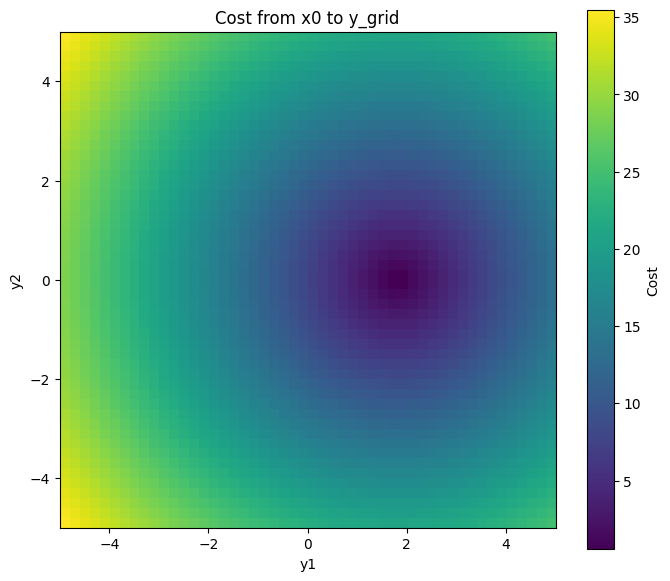

In [41]:
# Solve entropic OT problem between a centred Gaussian and a mixture of three Gaussians
dim = 2
L = torch.eye(dim)
c = 0.5
sigma = 0.3

sde = HeatBMTSDE(L=L, c=c, sigma=sigma)
ot_solver = EntropicOTSolver(sde=sde, normalize_variance=False)


x0 = torch.tensor([3.0, 0.0])
# Create a grid of y points and evaluate the cost from x0 to them using cost_matrix

# Define grid limits and resolution
y_min, y_max, n_grid = -5.0, 5.0, 50
y1 = torch.linspace(y_min, y_max, n_grid)
y2 = torch.linspace(y_min, y_max, n_grid)
y1g, y2g = torch.meshgrid(y1, y2, indexing='xy')
y_grid = torch.stack([y1g, y2g], dim=-1)

# Evaluate cost from x0 to each y in the grid using cost_matrix
costs = ot_solver.cost(x0.expand_as(y_grid), y_grid)


# Plot the cost as a heatmap
plt.figure(figsize=(8, 7))
plt.imshow(costs, extent=[y_min, y_max, y_min, y_max], cmap='viridis')
plt.colorbar(label='Cost')
plt.xlabel('y1')
plt.ylabel('y2')
plt.title('Cost from x0 to y_grid')
plt.show()

# Optimal transfer plan and the induced linear flow

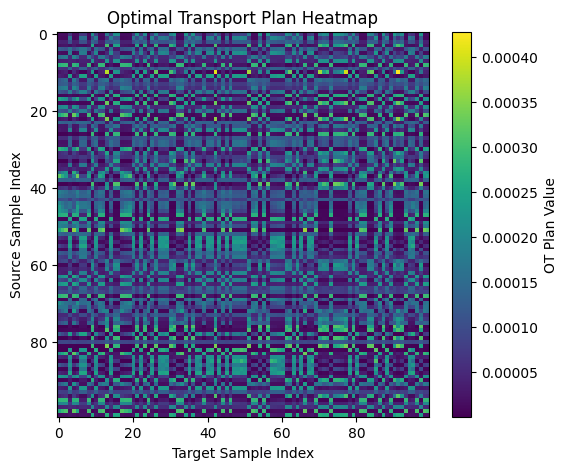

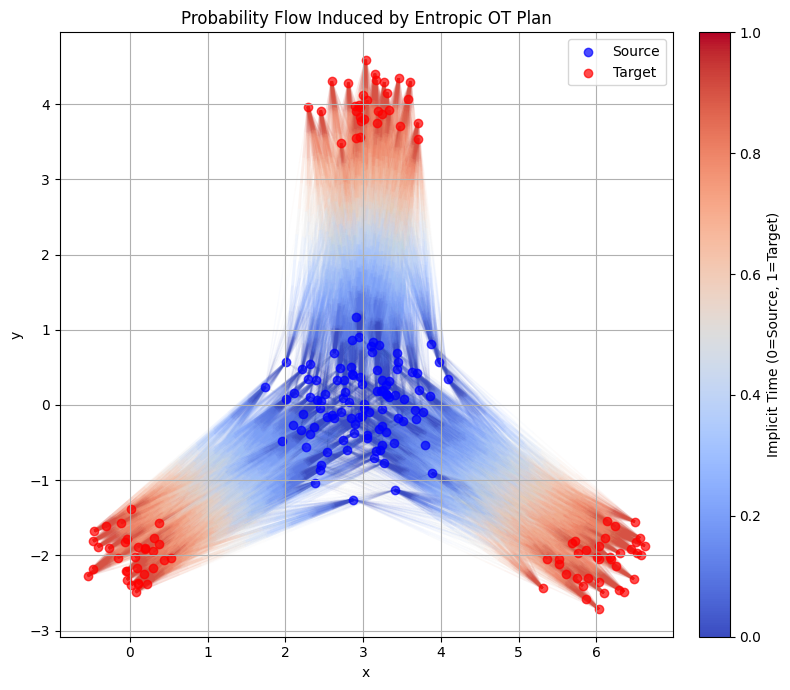

In [28]:
delta_mu = torch.tensor([3.0, 0.0])

mu0, sigma0 = torch.zeros(2) + delta_mu, torch.eye(2) * 0.3
R0 = torch.distributions.MultivariateNormal(loc=mu0, covariance_matrix=sigma0)

r = 2.0
mu11, sigma11 = torch.tensor([0.0, 2.0]) * r + delta_mu, torch.eye(2) * 0.1
mu12, sigma12 = torch.tensor([-1.5, -1.0]) * r + delta_mu, torch.eye(2) * 0.1
mu13, sigma13 = torch.tensor([1.5, -1.0]) * r + delta_mu, torch.eye(2) * 0.1
component_distribution = torch.distributions.MultivariateNormal(
    loc=torch.stack([mu11, mu12, mu13], dim=0), 
    covariance_matrix=torch.stack([sigma11, sigma12, sigma13], dim=0)
)
mixture_distribution = torch.distributions.Categorical(probs=torch.tensor([1/3, 1/3, 1/3]))
R1 = torch.distributions.MixtureSameFamily(
    mixture_distribution=mixture_distribution, 
    component_distribution=component_distribution
)

n_samples = 100
x0 = R0.sample((n_samples,))
x1 = R1.sample((n_samples,))

ot_plan = ot_solver.solve(x0, x1)



plt.figure(figsize=(6, 5))
plt.imshow(ot_plan, aspect='auto', cmap='viridis')
plt.colorbar(label='OT Plan Value')
plt.title('Optimal Transport Plan Heatmap')
plt.xlabel('Target Sample Index')
plt.ylabel('Source Sample Index')
plt.show()



# Ensure x0, x1, and ot_plan are on CPU and convert to numpy arrays
x0_np = x0.cpu().numpy() if hasattr(x0, "cpu") else x0.numpy()
x1_np = x1.cpu().numpy() if hasattr(x1, "cpu") else x1.numpy()
ot_plan_np = ot_plan.cpu().numpy() if hasattr(ot_plan, "cpu") else ot_plan.numpy()

# (Assume x0_np, x1_np, ot_plan_np are already CPU NumPy arrays.)
n = x0_np.shape[0]

plt.figure(figsize=(8, 7))
ax = plt.gca()
ax.scatter(x0_np[:, 0], x0_np[:, 1],
           color='blue', label='Source', alpha=0.7)
ax.scatter(x1_np[:, 0], x1_np[:, 1],
           color='red',  label='Target', alpha=0.7)

# parameters
max_plan = ot_plan_np.max()
threshold = 0.01 * max_plan

cmap = plt.get_cmap('coolwarm')
norm = Normalize(vmin=0, vmax=1)

segments = []
colors = []
widths = []

# how many sub‐segments per arrow
n_sub = 10

for i in range(n):
    for j in range(n):
        w = ot_plan_np[i, j]
        if w <= threshold:
            continue

        start = x0_np[i]
        end = x1_np[j]
        # generate equally‐spaced points along the line
        pts = np.linspace(start, end, n_sub + 1)

        # line thickness & overall alpha from flow magnitude
        flow = w / max_plan
        lw = 0.5 + 2.5 * flow
        alpha = flow * 0.3

        # build each tiny segment
        for k in range(n_sub):
            seg_t = [pts[k], pts[k + 1]]
            t = k / n_sub  # 0 at source, 1 at target
            # pick color from cmap and inject our α
            r, g, b, _ = cmap(norm(t))
            colors.append((r, g, b, alpha))
            widths.append(lw)
            segments.append(seg_t)

# assemble the LineCollection
lc = LineCollection(segments,
                    colors=colors,
                    linewidths=widths,
                    zorder=0)
ax.add_collection(lc)

# add colorbar for “time” scale
sm = cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array(np.linspace(0, 1, 100))   # dummy array
cbar = plt.colorbar(sm, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label('Implicit Time (0=Source, 1=Target)')

ax.set(title='Probability Flow Induced by Entropic OT Plan',
       xlabel='x', ylabel='y')
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()


# Synthetic Experiments

## Models

In [42]:
def timestep_embedding(
    timesteps: torch.Tensor,
    dim: int,
    max_period: int = 10000
) -> torch.Tensor:
    """
    Create sinusoidal timestep embeddings.

    parameters: 
        timesteps: [...]
        dim: int
        max_period: int

    returns:
        embedding: [..., dim]
    """
    dim_over_2, dim_mod_2 = divmod(dim, 2)
    freqs = torch.exp(
        -math.log(max_period) * torch.arange(0, dim_over_2, device=timesteps.device, dtype=timesteps.dtype) 
        / dim_over_2
    ) # [D/2]
    args = timesteps.unsqueeze(-1) * freqs.unsqueeze(0) # [..., 1] * [1, D/2] = [..., D/2]
    embedding = torch.cat([torch.cos(args), torch.sin(args)], dim=-1) # [..., D]

    if dim_mod_2 == 1:
        zero_column = embedding.new_zeros(embedding.shape[0], 1)
        embedding = torch.cat([embedding, zero_column], dim=-1)
    return embedding


class SiLU(torch.nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(x)


class FCs(torch.nn.Module):
    """
    Fully connected feedforward neural network with configurable number of layers.
    """
    def __init__(
        self,
        dim_in: int,
        dim_hid: int,
        dim_out: int,
        num_layers: int = 2
    ) -> None:
        """
        Fully connected feedforward neural network with configurable number of layers.

        Args:
            dim_in (int): Input feature dimension.
            dim_hid (int): Hidden layer dimension.
            dim_out (int): Output feature dimension.
            num_layers (int, optional): Total number of layers (including input and output layers). Default is 2.
        """
        super(FCs, self).__init__()
        self.model = torch.nn.Sequential()
        self.model.add_module('fc_in', torch.nn.Linear(dim_in, dim_hid))
        self.model.add_module('relu_in', torch.nn.ReLU())
        for i in range(num_layers - 2):
            self.model.add_module(f'fc_{i}', torch.nn.Linear(dim_hid, dim_hid))
            self.model.add_module(f'relu_{i}', torch.nn.ReLU())
        self.model.add_module('fc_out', torch.nn.Linear(dim_hid, dim_out))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.model(x)


class ResNet_FC(torch.nn.Module):
    """
    A fully connected network with an initial linear layer followed by a sequence of residual blocks.
    Each residual block consists of several linear layers with SiLU activations.
    """

    def __init__(self, data_dim: int, hidden_dim: int, num_res_blocks: int) -> None:
        """
        Initialize the ResNet_FC module.

        Args:
            data_dim (int): Input feature dimension.
            hidden_dim (int): Hidden layer dimension for all residual blocks.
            num_res_blocks (int): Number of residual blocks.
        """
        super().__init__()
        self.hidden_dim: int = hidden_dim
        self.map: torch.nn.Linear = torch.nn.Linear(data_dim, hidden_dim)
        self.res_blocks: torch.nn.ModuleList = torch.nn.ModuleList(
            [self.build_res_block() for _ in range(num_res_blocks)]
        )

    def build_linear(self, in_features: int, out_features: int) -> torch.nn.Linear:
        """
        Build a linear layer.

        Args:
            in_features (int): Number of input features.
            out_features (int): Number of output features.

        Returns:
            torch.nn.Linear: Linear layer.
        """
        return torch.nn.Linear(in_features, out_features)

    def build_res_block(self) -> torch.nn.Sequential:
        """
        Build a residual block consisting of several linear layers and SiLU activations.

        Returns:
            torch.nn.Sequential: Sequential container of layers forming a residual block.
        """
        hid: int = self.hidden_dim
        layers: list[torch.nn.Module] = []
        widths: list[int] = [hid] * 4
        for i in range(len(widths) - 1):
            layers.append(self.build_linear(widths[i], widths[i + 1]))
            layers.append(SiLU())
        return torch.nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass through the network.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, data_dim).

        Returns:
            torch.Tensor: Output tensor after passing through the network.
        """
        h = self.map(x)
        for res_block in self.res_blocks:
            h = (h + res_block(h)) / np.sqrt(2)
        return h

class TimestepBlock(torch.nn.Module):
    """
    Any module where forward() takes timestep embeddings as a second argument.
    """

    @abstractmethod
    def forward(self, x: torch.Tensor, emb: torch.Tensor) -> torch.Tensor:
        """
        Apply the module to `x` given `emb` timestep embeddings.
        """

class TimestepEmbedSequential(torch.nn.Sequential, TimestepBlock):
    """
    A sequential module that passes timestep embeddings to the children that
    support it as an extra input.
    """

    def forward(self, x: torch.Tensor, emb: torch.Tensor) -> torch.Tensor:
        for layer in self:
            if isinstance(layer, TimestepBlock):
                x = layer(x, emb)
            else:
                x = layer(x)
        return x


class GCNLayer(torch.nn.Module):
    """
    Graph Convolutional Network (GCN) Layer with Chebyshev polynomial support.

    Args:
        in_channels (int): Number of input channels/features.
        out_channels (int): Number of output channels/features.
        conv_order (int): Order of the Chebyshev polynomial (number of hops).
        laplacian (torch.Tensor): Laplacian or adjacency matrix.
        aggr_norm (bool, optional): Whether to normalize aggregation. Default is False.
        update_func (str or None, optional): Activation function to use after aggregation.
            Options: "sigmoid", "relu", "id", or None. Default is None.
        initialization (str, optional): Weight initialization method.
            Options: "xavier_uniform", "xavier_normal". Default is "xavier_uniform".
    """

    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        conv_order: int,
        laplacian: torch.Tensor,
        *, 
        aggr_norm: bool = False,
        update_func: str | None = None,
        initialization: str = "xavier_uniform",
    ) -> None:
        super().__init__()

        self.in_channels: int = in_channels
        self.out_channels: int = out_channels
        self.conv_order: int = conv_order
        self.laplacian: torch.Tensor = laplacian
        self.aggr_norm: bool = aggr_norm
        self.update_func: str | None = update_func
        self.initialization: str = initialization
        assert initialization in ["xavier_uniform", "xavier_normal"]

        self.weight: torch.nn.Parameter = torch.nn.Parameter(
            torch.Tensor(
                self.in_channels,
                self.out_channels,
                1 + self.conv_order,
            )
        )

        self.reset_parameters()

    def reset_parameters(self, gain: float = 1.414) -> None:
        """
        Reset the parameters of the layer using the specified initialization.

        Args:
            gain (float, optional): Gain value for initialization. Default is 1.414.
        """
        if self.initialization == "xavier_uniform":
            torch.nn.init.xavier_uniform_(self.weight, gain=gain)
        elif self.initialization == "xavier_normal":
            torch.nn.init.xavier_normal_(self.weight, gain=gain)

    def aggr_norm_func(self, conv_operator: torch.Tensor, x: torch.Tensor) -> torch.Tensor:
        """
        Normalize the aggregation by the neighborhood size.

        Args:
            conv_operator (torch.Tensor): The convolution operator (adjacency or Laplacian matrix).
            x (torch.Tensor): Input tensor.

        Returns:
            torch.Tensor: Normalized tensor.
        """
        neighborhood_size = torch.sum(conv_operator.to_dense(), dim=1)
        neighborhood_size_inv = 1 / neighborhood_size
        neighborhood_size_inv[~(torch.isfinite(neighborhood_size_inv))] = 0

        x = torch.einsum("i,ij->ij ", neighborhood_size_inv, x)
        x[~torch.isfinite(x)] = 0
        return x

    def update(self, x: torch.Tensor) -> torch.Tensor | None:
        """
        Apply the update (activation) function to the input.

        Args:
            x (torch.Tensor): Input tensor.

        Returns:
            torch.Tensor or None: Activated tensor or None if update_func is not recognized.
        """
        if self.update_func == "sigmoid":
            return torch.sigmoid(x)
        if self.update_func == "relu":
            return torch.nn.functional.relu(x)
        if self.update_func == "id":
            return x
        return None

    def chebyshev_conv(
        self,
        conv_operator: torch.Tensor,
        conv_order: int,
        x: torch.Tensor
    ) -> torch.Tensor:
        """
        Perform Chebyshev polynomial convolution.

        Args:
            conv_operator (torch.Tensor): The convolution operator (adjacency or Laplacian matrix).
            conv_order (int): Order of the Chebyshev polynomial.
            x (torch.Tensor): Input tensor of shape (num_simplices, num_channels).

        Returns:
            torch.Tensor: Tensor of shape (num_simplices, num_channels, conv_order).
        """
        num_simplices, num_channels = x.shape
        X = torch.empty(size=(num_simplices, num_channels, conv_order))
        X[:, :, 0] = torch.mm(conv_operator, x)
        for k in range(1, conv_order):
            X[:, :, k] = torch.mm(conv_operator, X[:, :, k - 1])
            if self.aggr_norm:
                X[:, :, k] = self.aggr_norm_func(conv_operator, X[:, :, k])

        return X

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass of the GCN layer.

        Args:
            x (torch.Tensor): Input tensor of shape (num_simplices, in_channels).

        Returns:
            torch.Tensor: Output tensor of shape (num_simplices, out_channels).
        """
        num_simplices, _ = x.shape
        x_identity = torch.unsqueeze(x, 2)

        if self.conv_order > 0:
            x = self.chebyshev_conv(self.laplacian, self.conv_order, x)
            x = torch.cat((x_identity, x), 2)

        y = torch.einsum("nik,iok->no", x, self.weight)

        if self.update_func is None:
            return y

        return self.update(y)


class GCNBlock(torch.nn.Module):
    """
    Graph Convolutional Network (GCN) module composed of multiple GCNLayer layers.

    Args:
        in_channels (int): Number of input features per node.
        hidden_channels (int): Number of hidden units in each hidden GCN layer.
        laplacian (torch.Tensor): Laplacian matrix or convolution operator.
        conv_order (int, optional): Order of the Chebyshev polynomial convolution. Default is 1.
        aggr_norm (bool, optional): Whether to apply aggregation normalization. Default is False.
        update_func (Optional[str], optional): Update function to use in GCNLayer ('relu', 'id', etc.). Default is None.
        n_layers (int, optional): Number of GCN layers. Default is 2.
    """
    def __init__(
        self,
        in_channels: int,
        hidden_channels: int,
        laplacian: torch.Tensor,
        *,
        conv_order: int = 1,
        aggr_norm: bool = False,
        update_func: str = None,
        n_layers: int = 2,
    ) -> None:
        super().__init__()
        self.layers: torch.nn.ModuleList = torch.nn.ModuleList(
            [
                GCNLayer(
                    in_channels=in_channels,
                    out_channels=hidden_channels,
                    conv_order=conv_order, 
                    laplacian=laplacian,
                )
            ]
        )

        for i in range(n_layers - 1):
            if i == n_layers - 2: 
                out_channels = 1
                layer_update_func = 'id'
            else: 
                out_channels = hidden_channels
                layer_update_func = 'relu'
            self.layers.append(
                GCNLayer(
                    in_channels=hidden_channels,
                    out_channels=out_channels,
                    conv_order=conv_order,
                    laplacian=laplacian,
                    aggr_norm=aggr_norm,
                    update_func=layer_update_func,
                )
            )
            
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass through the GCN.

        Args:
            x (torch.Tensor): Input tensor of shape (num_nodes, in_channels).

        Returns:
            torch.Tensor: Output tensor after passing through all GCN layers.
        """
        for layer in self.layers:
            x = layer(x)
        return x


class GCN(torch.nn.Module):
    """
    Network using a combination of GCN and ResNet_FC modules with time embedding.

    Args:
        laplacian (torch.Tensor): Laplacian matrix of the graph (shape: [N, N]).
        hidden_dim (int, optional): Number of hidden units in each layer. Default is 256.
        time_embed_dim (int, optional): Dimensionality of the time embedding. Default is 128.
    """
    def __init__(
        self,
        laplacian: torch.Tensor,
        hidden_dim: int = 256,
        time_embed_dim: int = 128
    ) -> None:
        super().__init__()
        data_dim: int = laplacian.shape[-1]

        self.time_embed_dim: int = time_embed_dim
        hid: int = hidden_dim

        self.t_module: torch.nn.Sequential = torch.nn.Sequential(
            torch.nn.Linear(self.time_embed_dim, hid),
            SiLU(),
            torch.nn.Linear(hid, hid),
        )

        self.x_module1: GCN = GCNBlock(
            in_channels=1,
            hidden_channels=hidden_dim,
            n_layers=2,
            laplacian=laplacian
        )
        self.x_module2: ResNet_FC = ResNet_FC(
            data_dim,
            hidden_dim,
            num_res_blocks=0
        )

        self.out_module: torch.nn.Sequential = torch.nn.Sequential(
            torch.nn.Linear(hid, hid),
            SiLU(),
            torch.nn.Linear(hid, data_dim),
        )

    @property
    def inner_dtype(self) -> torch.dtype:
        """
        Get the dtype used by the torso of the model.

        Returns:
            torch.dtype: The dtype of the model's parameters.
        """
        # Note: input_blocks is not defined in this class; this property may need to be updated.
        return next(self.input_blocks.parameters()).dtype

    def forward(self, t: torch.Tensor, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass of the GCNPolicy.

        Args:
            t (torch.Tensor): 1-D tensor of timesteps.
            x (torch.Tensor): Input tensor of shape [N, C, ...].

        Returns:
            torch.Tensor: Output tensor after processing through the network.
        """
        # Ensure t has shape [T]
        if len(t.shape) == 0:
            t = t[None]

        t_emb: torch.Tensor = timestep_embedding(t, self.time_embed_dim)
        t_out: torch.Tensor = self.t_module(t_emb)

        x = x.unsqueeze(-1)  # Add feature dimension for GCN
        x_out = torch.empty_like(x)
        for i in range(x.shape[0]):
            x_out[i] = self.x_module1(x[i])

        x_out = x_out.squeeze(-1)
        x_out = self.x_module2(x_out)
        out = self.out_module(x_out + t_out)

        return out


class ResidualNN(torch.nn.Module):
    """
    Residual Neural Network module for time-dependent input.

    Args:
        data_dim (int): Dimensionality of the input data.
        hidden_dim (int, optional): Number of hidden units in each layer. Default is 256.
        time_embed_dim (int, optional): Dimensionality of the time embedding. Default is 128.
        num_res_block (int, optional): Number of residual blocks in the ResNet_FC module. Default is 1.
    """
    def __init__(
        self, 
        data_dim: int, 
        hidden_dim: int = 256, 
        time_embed_dim: int = 128, 
        num_res_block: int = 1
    ) -> None:
        super().__init__()

        self.time_embed_dim = time_embed_dim
        hid = hidden_dim

        self.t_module = torch.nn.Sequential(
            torch.nn.Linear(self.time_embed_dim, hid),
            SiLU(),
            torch.nn.Linear(hid, hid),
        )

        self.x_module = ResNet_FC(data_dim, hidden_dim, num_res_blocks=num_res_block)

        self.out_module = torch.nn.Sequential(
            torch.nn.Linear(hid, hid),
            SiLU(),
            torch.nn.Linear(hid, data_dim),
        )

    def forward(self, t: torch.Tensor, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass of the ResidualNN.

        Args:
            t (torch.Tensor): 1-D tensor of timesteps.
            x (torch.Tensor): Input tensor of shape [N x C x ...].

        Returns:
            torch.Tensor: Output tensor after processing through the network.
        """
        t = torch.atleast_1d(t)

        t_emb = timestep_embedding(timesteps=t, dim=self.time_embed_dim)
        t_out = self.t_module(t_emb)
        x_out = self.x_module(x)
        out = self.out_module(x_out + t_out)
        return out


class MLP(torch.nn.Module):
    def __init__(self, dim: int, hidden_dim: int = 10):
        super().__init__()
        self.dim = dim
        self.nn = torch.nn.Sequential(
            torch.nn.Linear(1, hidden_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_dim, hidden_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_dim, dim),
        )

    def __call__(self, t: torch.Tensor) -> torch.Tensor:
        return self.nn(t.unsqueeze(-1))


class ResidualMLP(torch.nn.Module):
    def __init__(self, dim: int, hidden_dim: int = 64, num_layers: int = 3):
        super().__init__()
        self.dim = dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        # Input layer: now takes both t and x as input
        self.input_layer = torch.nn.Linear(1 + dim, hidden_dim)

        # Hidden layers
        self.hidden_layers = torch.nn.ModuleList()
        for _ in range(num_layers - 1):
            self.hidden_layers.append(torch.nn.Linear(hidden_dim, hidden_dim))

        # Output layer
        self.output_layer = torch.nn.Linear(hidden_dim, dim)

        self.activation = torch.nn.ReLU()

    def forward(self, t: torch.Tensor, x: torch.Tensor) -> torch.Tensor:
        # Concatenate t and x along the last dimension
        t = t.unsqueeze(-1) if t.ndim == x.ndim - 1 else t
        inp = torch.cat([t, x], dim=-1)
        out = self.input_layer(inp)
        for layer in self.hidden_layers:
            residual = out
            out = self.activation(out)
            out = layer(out)
            out = out + residual  # Residual connection
        out = self.activation(out)
        out = self.output_layer(out)
        return out

## Training and Evaluation

In [51]:
from torch_ema import ExponentialMovingAverage


def train(
    sde: SDE,
    ot_solver: EntropicOTSolver,
    model: torch.nn.Module, 
    x0: torch.Tensor, 
    x1: torch.Tensor, 
    *, 
    num_epochs: int = 100, 
    batch_size: int = 64, 
    num_samples_per_epoch: int = 1024, 
    optimizer: torch.optim.Optimizer | None = None,
    lr: float = 0.001, 
    time_sampler: TimeSampler | None = None,
) -> list[float]:
    """
    Trains a model to match the two distributions x0 and x1. 
    TODO Maybe move OT solver to be an argument.
    """

    num_batches_per_epoch = num_samples_per_epoch // batch_size
    dataset = MatchingDataset(x0, x1, time_sampler=time_sampler)
    batch_sampler = OTBatchSampler(dataset, ot_solver, batch_size=batch_size, num_samples=num_samples_per_epoch)
    data_loader = MatchingDataLoader(dataset, batch_sampler=batch_sampler)

    if optimizer is None:
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    objective = torch.nn.MSELoss()
    ema = ExponentialMovingAverage(model.parameters(), decay=0.999)

    per_batch_losses = []
    with tqdm(range(num_epochs), desc="Epochs") as pbar:
        for _ in pbar:
            epoch_loss = 0.0
            for batch_t, batch_x0, batch_x1 in data_loader:
                # sample xt, compute targets and predictions
                batch_x = sde.marginal_distribution(t=batch_t, x0=batch_x0, x1=batch_x1).sample()
                ut = bridge_control(sde=sde, t=batch_t, x=batch_x, x1=batch_x1)
                ut_preds = model(batch_t, batch_x)

                # Generic loss computation and backprop
                loss = objective(ut, ut_preds)
                loss.backward()
                optimizer.step()
                batch_loss = loss.item()
                per_batch_losses.append(batch_loss)
                epoch_loss += batch_loss
                optimizer.zero_grad()
                ema.update()
            avg_loss = epoch_loss / num_batches_per_epoch
            pbar.set_postfix({"avg_loss": f"{avg_loss:.4f}"})

    return per_batch_losses


def wasserstein_distance(x0: torch.Tensor, x1: torch.Tensor, *, p: int = 1, blur: float = 0.05) -> float:
    if p == 1:
        return SamplesLoss(loss="sinkhorn", p=1, blur=.05)(x0, x1)
    if p == 2: 
        return SamplesLoss(loss="sinkhorn", p=2, blur=.05)(x0, x1).sqrt() 
    raise ValueError(f"We only use Wasserstein-1 and Wasserstein-2 distances for model evaluation, not {p}.")

## Simple 2d example

Epochs: 100%|██████████| 1000/1000 [02:16<00:00,  7.31it/s, avg_loss=0.2906]


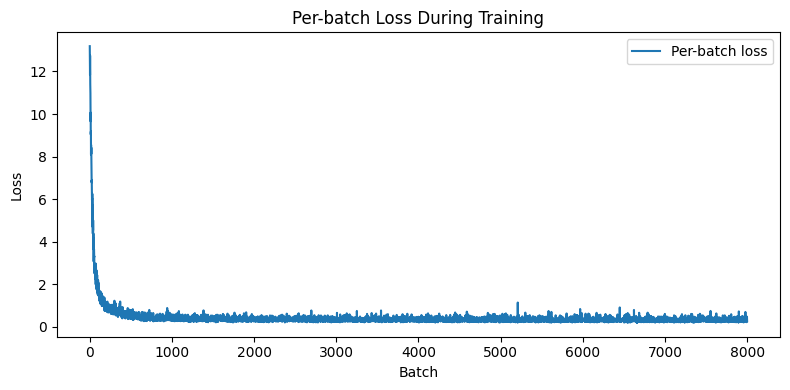

In [56]:
delta_mu = torch.tensor([3.0, 0.0])

mu0, sigma0 = torch.zeros(2) + delta_mu, torch.eye(2) * 0.3
R0 = torch.distributions.MultivariateNormal(loc=mu0, covariance_matrix=sigma0)

r = 3.0
mu11, sigma11 = torch.tensor([0.0, 2.0]) * r + delta_mu, torch.eye(2) * 0.1
mu12, sigma12 = torch.tensor([-1.5, -1.0]) * r + delta_mu, torch.eye(2) * 0.1
mu13, sigma13 = torch.tensor([1.5, -1.0]) * r + delta_mu, torch.eye(2) * 0.1
component_distribution = torch.distributions.MultivariateNormal(
    loc=torch.stack([mu11, mu12, mu13], dim=0), 
    covariance_matrix=torch.stack([sigma11, sigma12, sigma13], dim=0)
)
mixture_distribution = torch.distributions.Categorical(probs=torch.tensor([1/3, 1/3, 1/3]))
R1 = torch.distributions.MixtureSameFamily(
    mixture_distribution=mixture_distribution, 
    component_distribution=component_distribution
)

n_samples = 1000
x0 = R0.sample((n_samples,))
x1 = R1.sample((n_samples,))

sigma = 0.2
c = 0.0


L = torch.eye(2)
sde = HeatBMTSDE(L=L, c=c, sigma=sigma)
ot_solver = EntropicOTSolver(sde=sde, normalize_variance=True)
time_sampler = DiscreteTimeSampler(timesteps=UniformTimesteps(n=100))
# time_sampler = UniformTimeSampler()

model = ResidualNN(data_dim=2)
# model = GCN(L)
per_batch_losses = train(sde, ot_solver, model, x0, x1, num_epochs=1000, batch_size=128, num_samples_per_epoch=1024, lr=0.0001, time_sampler=time_sampler)


# Plot per-batch loss after training
plt.figure(figsize=(8, 4))
plt.plot(per_batch_losses, label="Per-batch loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.title("Per-batch Loss During Training")
plt.legend()
plt.tight_layout()
plt.show()

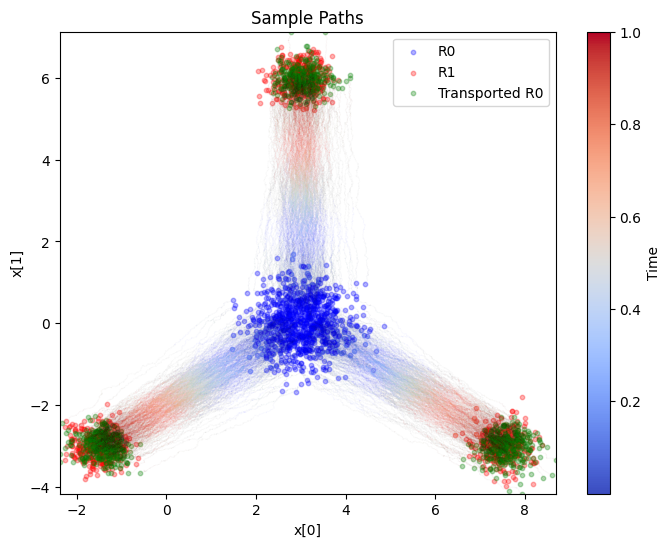

In [57]:
with torch.no_grad():
    model_control = ModelControl(model=model)
    sde_solver = EulerMaruyamaSolver(sde=sde, n=1000)
    x0s_test = R0.sample((1000,))
    x1s_test = R1.sample((1000,))

    xts, ts = sde_solver.sample_path(x0s_test, control=model_control)
    xts = sde.inverse_transform(xts)


# Assume xts shape: [N, T, D] or [T, D] if single batch
xts_np = xts.detach().cpu().numpy()
ts_np = ts.detach().cpu().numpy()

# Ensure shape is [N, T, D]
if xts_np.ndim == 2:
    xts_np = xts_np[None, ...]  # [1, T, D]

N, T, D = xts_np.shape
assert D == 2, "D must be 2 for 2D plotting"

# Prepare segments for LineCollection: each path is (T, 2), segments are (T-1, 2, 2)
segments = []
colors = []
norm = plt.Normalize(ts_np.min(), ts_np.max())
# Use a blue-to-red colormap
cmap = plt.get_cmap('coolwarm')  # blue (low) to red (high)

# Use a single alpha value for all lines
global_alpha = 0.02

for i in range(N):
    points = xts_np[i, :, :2]
    segs = np.stack([points[:-1], points[1:]], axis=1)  # (T-1, 2, 2)
    segments.append(segs)
    # Color for each segment (time-varying colormap, fixed alpha)
    t_mid = (ts_np[:-1] + ts_np[1:]) / 2
    seg_colors = cmap(norm(t_mid))
    seg_colors[:, -1] = global_alpha  # Set the same alpha for all segments
    colors.append(seg_colors)

# Concatenate all segments and colors
all_segments = np.concatenate(segments, axis=0)
all_colors = np.concatenate(colors, axis=0)

fig, ax = plt.subplots(figsize=(8, 6))
lc = LineCollection(all_segments, colors=all_colors, linewidths=1)
ax.add_collection(lc)

# Add scatterplot of xmids, black markers
x0s_test_np = x0s_test.detach().cpu().numpy()
x1s_test_np = x1s_test.detach().cpu().numpy()
x1s_pred_np = xts_np[:, -1]
ax.scatter(x0s_test_np[:, 0], x0s_test_np[:, 1], color='blue', marker='o', s=10, alpha=0.3, label='R0')
ax.scatter(x1s_test_np[:, 0], x1s_test_np[:, 1], color='red', marker='o', s=10, alpha=0.3, label='R1')
ax.scatter(x1s_pred_np[:, 0], x1s_pred_np[:, 1], color='green', marker='o', s=10, alpha=0.3, label='Transported R0')
ax.legend(loc='upper right')


# Set axis limits
all_x = xts_np[..., 0].ravel()
all_y = xts_np[..., 1].ravel()
ax.set_xlim(all_x.min(), all_x.max())
ax.set_ylim(all_y.min(), all_y.max())

ax.set_xlabel('x[0]')
ax.set_ylabel('x[1]')
ax.set_title('Sample Paths')

# Colorbar for time
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, label='Time')
plt.show()


# Brain Connectome Experiment

## Data download

In [58]:
import pandas as pd
import os


def download_brain_regions_centroids(data_dir: str = './datasets/brain_signals/'):
    csv_url = "https://bitbucket.org/dpat/tools/raw/master/REF/ATLASES/HCP-MMP1_UniqueRegionList.csv"
    brain_regions_centroids_df = pd.read_csv(
        csv_url, 
        usecols=["x-cog", "y-cog", "z-cog"],
        dtype={"x-cog": float, "y-cog": float, "z-cog": float},
    ).rename(columns={"x-cog": "x", "y-cog": "y", "z-cog": "z"})
    brain_regions_centroids_df.to_csv(os.path.join(data_dir, "brain_regions_centroids.csv"), index=False)


def load_brain_regions_centroids(data_dir: str = './datasets/brain_signals/'):
    return pd.read_csv(os.path.join(data_dir, "brain_regions_centroids.csv"))


def plot_brain_signal_3d(signal: torch.Tensor | None = None, width: int = 500, height: int = 500, marker_size: int = 5):
    df = load_brain_regions_centroids()
    if signal is not None:
        df = df.assign(signal=signal.detach().cpu().numpy())
        fig = px.scatter_3d(df, x='x', y='y', z='z', color='signal')
    else:
        fig = px.scatter_3d(df, x='x', y='y', z='z')
    fig.update_traces(marker_size=marker_size)
    fig.update_layout(width=width, height=height)
    fig.show()
    return fig 


def plot_brain_signal_2d(signal: torch.Tensor | None = None, width: int = 400, height: int = 400, marker_size: int = 6):
    df = load_brain_regions_centroids()
    if signal is not None:
        df = df.assign(signal=signal.detach().cpu().numpy())
        fig = px.scatter(df, x='x', y='y', color='signal')
    else:
        fig = px.scatter(df, x='x', y='y')
    fig.update_traces(marker_size=marker_size)
    fig.update_layout(width=width, height=height)
    fig.show()
    return fig 


def load_brain_data() -> tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
    """
    Loads the brain data from the .mat files and splits it into training and test sets.
    Returns:
        x0: [N, D] Training samples from the aligned dataset.
        x1: [N, D] Training samples from the liberal dataset.
        x0_train: [N_train, D] Training samples from the aligned dataset.
        x0_test: [N_test, D] Test samples from the aligned dataset.
        x1_train: [N_train, D] Training samples from the liberal dataset.
        x1_test: [N_test, D] Test samples from the liberal dataset.
    """
    laplacian = scipy.io.loadmat('./datasets/brain_signals/lap.mat')['L']

    x0 = scipy.io.loadmat('./datasets/brain_signals/aligned.mat')['Xa'].T
    x1 = scipy.io.loadmat('./datasets/brain_signals/liberal.mat')['Xl'].T

    # Split data into training and test sets
    num_train = int(0.8 * x0.shape[0])
    num_test = x0.shape[0] - num_train
    x = np.arange(x0.shape[0])
    random_perm = np.random.permutation(x)
    train_ids, test_ids = random_perm[:num_train], random_perm[num_train:]
    x0_train, x0_test = x0[train_ids], x0[test_ids]
    x1_train, x1_test = x1[train_ids], x1[test_ids]
    return laplacian, x0, x1, x0_train, x0_test, x1_train, x1_test

## Modelling

In [59]:
L, x0, x1, x0_train, x0_test, x1_train, x1_test = as_tensors(*load_brain_data())

c = 2.0
sigma = 0.2
sde = HeatBMTSDE(L=L, c=c, sigma=sigma)
ot_solver = EntropicOTSolver(sde=sde, normalize_variance=False)
# model = GCN(L)
model = ResidualNN(data_dim=x0.shape[-1])


training_losses = train(sde, ot_solver, model, x0_train, x1_train, num_epochs=100, batch_size=64, num_samples_per_epoch=1024, lr=0.001)
px.line(training_losses)

: 

In [168]:
sde_solver = EulerMaruyamaSolver(sde=sde, n=100)
with torch.no_grad():
    x0_test_pred = sde_solver.sample_from_terminal(x0=x0_test, control=ModelControl(model))
    x0_test_pred = sde.inverse_transform(x0_test_pred)
    test_w1 = wasserstein_distance(x1_test, x0_test_pred, p=1)
    test_w2 = wasserstein_distance(x1_test, x0_test_pred, p=2)

print(f"Wasserstein-1 distance: {test_w1:.4f}")
print(f"Wasserstein-2 distance: {test_w2:.4f}")

plot_brain_signal_2d(x0_test[0]);
plot_brain_signal_2d(x0_test_pred[0]);
plot_brain_signal_2d(x1_test[0]);

Wasserstein-1 distance: 21.9974
Wasserstein-2 distance: 15.6121
